In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
#from Preprocessing import clean_text, remove_names, entity_recognizing, remove_url
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import l2
import re
import os

%matplotlib inline
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
path = "/content/drive/MyDrive/IAS/NLP_and_Web/data/fox_news.csv"
df_training = pd.read_csv(path)
df_training = df_training.rename(columns={'class': 'label'})
df_training.head()

,Unnamed: 0,comment,label
0,0,Merkel would never say NO,2
1,1,"Expect more and more women to be asking .. ""wh...",2
2,2,Groping people in public wasn't already illega...,0
3,3,"Merkel, possible the only person in charge who...",2
4,4,"They know very well, no means NO They need to ...",2


In [ ]:
df_training['label'].value_counts()


0    1083
2     430
Name: label, dtype: int64

In [ ]:
df_training.duplicated(subset=['comment']).value_counts()

False    1513
dtype: int64

In [ ]:
#converting hate label(2) to hate label(1)
df_training.replace({2:1}, inplace=True)
df_training

,Unnamed: 0,comment,label
0,0,Merkel would never say NO,1
1,1,"Expect more and more women to be asking .. ""wh...",1
2,1,Groping people in public wasn't already illega...,0
3,3,"Merkel, possible the only person in charge who...",1
4,4,"They know very well, no means NO They need to ...",1
...,...,...,...
1508,1523,"No, 10000 Loose nuts off their meds",1
1509,1524,Just another ugly leftist.,1
1510,1525,"True. Most leftists ,esp female leftists have ...",1
1511,1526,"First, lets get this straight",1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d1fcaacd0>],
      dtype=object)

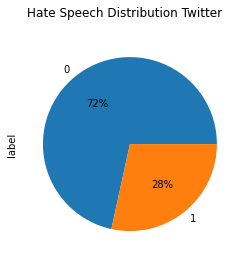

In [ ]:
df_training.label.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Hate Speech Distribution Twitter')


## class = class label for Fox news. 1 - hate speech 0 - non hate

In [ ]:
def filter_hatespeech_texts(df):
    
    def filter_texts(text):
        return re.sub('@.\:|!|@\w+:|@[\w]*|&#[0-9]*;|#\w+|RT|\/\/t.co\/\w+|&gt|&lt', '', text)

    def postprocess_filter_texts(text):
        
        return df

    df['comment'] = df['comment'].apply(filter_texts)
    df.replace("", np.nan, inplace=True)
    df = df.dropna()
    
    
    return df

df_training = filter_hatespeech_texts(df_training)

In [ ]:
TEXT_COLUMN = "comment"
LABEL_COLUMN = "label"

print("Converting to lower-case")
df_training[TEXT_COLUMN] = df_training[TEXT_COLUMN].str.lower()
print(df_training.head())

Converting to lower-case
   Unnamed: 0                                            comment  label
0           0                          merkel would never say no      1
1           1  expect more and more women to be asking .. "wh...      1
2           1  groping people in public wasn't already illega...      0
3           3  merkel, possible the only person in charge who...      1
4           4  they know very well, no means no they need to ...      1


In [ ]:
df_training['doc_len'] = df_training[TEXT_COLUMN].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df_training['doc_len'].mean() + df_training['doc_len'].std()).astype(int)

In [ ]:
df_training.head()

,Unnamed: 0,comment,label,doc_len
0,0,merkel would never say no,1,5
1,1,"expect more and more women to be asking .. ""wh...",1,28
2,1,groping people in public wasn't already illega...,0,12
3,3,"merkel, possible the only person in charge who...",1,80
4,4,"they know very well, no means no they need to ...",1,20


## Splitting the data

In [ ]:
seed = 11
test_size = 0.0
# categories = ['not hate speech', 'hate speech]
categories = [0,1]
def split_dataset(df, seed, test_size):
    #train, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    #val, test = train_test_split(test, test_size=0.5, random_state=seed, shuffle=True)
    #return train.comment, train.label, test.comment, test.label  #, val.comment, val.label
    return df.comment, df.label, df.comment, df.label

In [ ]:
train, train_targets, test, test_targets = split_dataset(df_training, seed=seed, test_size=test_size)

In [ ]:
type(train_targets.values)

numpy.ndarray

In [ ]:
def calculate_dataset_class_distribution(targets, categories):
    df = pd.DataFrame({'category':targets})
    s = df.category.value_counts(normalize=True)
    s = s.reindex(categories)
    return [s.index[0], s[0]], [s.index[1], s[1]]

In [ ]:
train_class_distribution = calculate_dataset_class_distribution(train_targets, categories)
test_class_distribution = calculate_dataset_class_distribution(test_targets, categories)

In [ ]:
embed_size = 300  # how big is each word vector
max_features = None  # how many unique words to use (i.e num rows in embedding vector)
maxlen = max_seq_len  # max number of words in a question to use #99.99%

def encode(data, label):
    # fill up the missing values
    X = data.fillna("_na_").values
    total_texts = df_training.comment.fillna("_na_").values
    
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(list(total_texts))
    X = tokenizer.texts_to_sequences(X)
    vocab_size = len(tokenizer.word_index) + 1
    print(tokenizer.word_index)
    
    # Pad the sentences
    X = pad_sequences(X, maxlen=maxlen)
    print(X.shape)
    
    # Get the target values
    y = pd.get_dummies(label.values)
    print(y.shape)
    #le = LabelEncoder()
    #le.fit(Y_train)
    #encoded_Y = le.transform(Y_train)
    return X,y,vocab_size
    

In [ ]:
max_seq_len

56

In [ ]:
type(train)

pandas.core.series.Series

In [ ]:
# FETCH DATA, LABELS, DICTIONARIES
X_train, y_train, vocab_size = encode(train, train_targets)
X_test, y_test, vocab_size = encode(test, test_targets)

print(vocab_size)

{'the': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'is': 6, 'in': 7, 'that': 8, 'you': 9, 'i': 10, 'are': 11, 'for': 12, 'it': 13, 'they': 14, 'not': 15, 'have': 16, 'be': 17, 'with': 18, 'on': 19, 'this': 20, 'as': 21, 'was': 22, 'people': 23, 'who': 24, 'all': 25, 'your': 26, 'will': 27, 'what': 28, 'but': 29, 'or': 30, 'their': 31, 'if': 32, 'no': 33, 'just': 34, 'so': 35, 'we': 36, 'do': 37, 'by': 38, 'like': 39, 'an': 40, 'has': 41, 'from': 42, 'at': 43, 'would': 44, 'can': 45, 'get': 46, 'about': 47, 'he': 48, 'she': 49, 'should': 50, "don't": 51, 'them': 52, 'how': 53, 'there': 54, 'more': 55, 'because': 56, "it's": 57, 'up': 58, 'one': 59, 'my': 60, 'than': 61, 'out': 62, 'only': 63, 'when': 64, 'his': 65, 'why': 66, 'any': 67, 'our': 68, 'white': 69, 'make': 70, 'some': 71, 'obama': 72, 'then': 73, 'these': 74, 'her': 75, 'been': 76, 'want': 77, 'were': 78, 'think': 79, 'did': 80, 'never': 81, 'does': 82, 'work': 83, 'after': 84, 'flag': 85, 'country': 86, 'know': 87, 'many': 88, 

In [ ]:
y_train

,0,1
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1
...,...,...
1508,0,1
1509,0,1
1510,0,1
1511,0,1


Loading the Movies dataset and preparing the encodings for each utterences

In [ ]:
df_AllMovie = pd.read_csv('/content/drive/MyDrive/IAS/NLP_and_Web/data/all_movies.csv')
df_AllMovie

,Unnamed: 0,movie_id,batch_id,majority_answer,text,movie_name
0,0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX
1,1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX
2,2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX
3,3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX
4,4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX
...,...,...,...,...,...,...
10683,10683,TheWolfofWallStreet2013BluRay_3724,3859903933,0,Sell me this pen.,TheWolfofWallStreet
10684,10684,TheWolfofWallStreet2013BluRay_3725,3859903933,0,"Well, it's a nice pen.",TheWolfofWallStreet
10685,10685,TheWolfofWallStreet2013BluRay_3726_3727,3859903933,0,You can use the pen to write down thoughts fro...,TheWolfofWallStreet
10686,10686,TheWolfofWallStreet2013BluRay_3728,3859903933,0,Sell me this pen.,TheWolfofWallStreet


In [ ]:
#df_AllMovie.drop(columns=['Unnamed: 0','Unnamed: 6','Unnamed: 7'],inplace=True)

####combining (Hate + offensive) labels in all movies dataset together as Hate

In [ ]:
#make the all movies dataset as 0: neither, 1:hate (the hate and offensive labels are clubbed together into hate(1))
df_AllMovie["majority_answer"].replace({2:1}, inplace=True)
df_AllMovie

,Unnamed: 0,movie_id,batch_id,majority_answer,text,movie_name
0,0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX
1,1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX
2,2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX
3,3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX
4,4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX
...,...,...,...,...,...,...
10683,10683,TheWolfofWallStreet2013BluRay_3724,3859903933,0,Sell me this pen.,TheWolfofWallStreet
10684,10684,TheWolfofWallStreet2013BluRay_3725,3859903933,0,"Well, it's a nice pen.",TheWolfofWallStreet
10685,10685,TheWolfofWallStreet2013BluRay_3726_3727,3859903933,0,You can use the pen to write down thoughts fro...,TheWolfofWallStreet
10686,10686,TheWolfofWallStreet2013BluRay_3728,3859903933,0,Sell me this pen.,TheWolfofWallStreet


In [ ]:
X_test_AllMovie, y_test_AllMovie, vocab_size = encode(df_AllMovie['text'], df_AllMovie['majority_answer'])
print(vocab_size)

{'the': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'is': 6, 'in': 7, 'that': 8, 'you': 9, 'i': 10, 'are': 11, 'for': 12, 'it': 13, 'they': 14, 'not': 15, 'have': 16, 'be': 17, 'with': 18, 'on': 19, 'this': 20, 'as': 21, 'was': 22, 'people': 23, 'who': 24, 'all': 25, 'your': 26, 'will': 27, 'what': 28, 'but': 29, 'or': 30, 'their': 31, 'if': 32, 'no': 33, 'just': 34, 'so': 35, 'we': 36, 'do': 37, 'by': 38, 'like': 39, 'an': 40, 'has': 41, 'from': 42, 'at': 43, 'would': 44, 'can': 45, 'get': 46, 'about': 47, 'he': 48, 'she': 49, 'should': 50, "don't": 51, 'them': 52, 'how': 53, 'there': 54, 'more': 55, 'because': 56, "it's": 57, 'up': 58, 'one': 59, 'my': 60, 'than': 61, 'out': 62, 'only': 63, 'when': 64, 'his': 65, 'why': 66, 'any': 67, 'our': 68, 'white': 69, 'make': 70, 'some': 71, 'obama': 72, 'then': 73, 'these': 74, 'her': 75, 'been': 76, 'want': 77, 'were': 78, 'think': 79, 'did': 80, 'never': 81, 'does': 82, 'work': 83, 'after': 84, 'flag': 85, 'country': 86, 'know': 87, 'many': 88, 

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, embed_size, input_length=X_train.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 32
lr = 0.001


model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_size, input_length=X_train.shape[1]),
        tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        tf.keras.layers.Dense(2, activation = 'softmax')
  ])

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 56, 300)           2344200   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 2,437,770
Trainable params: 2,437,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val


NameError: ignored

In [ ]:
val_targets

NameError: ignored

In [ ]:
history = model.fit(X_train, y_train, 
      epochs=epochs,  
      verbose=1, 
      validation_split=0.10,
      batch_size=batch_size)

Epoch 1/20
43/43 [==============================] - 7s 108ms/step - loss: 3.8422 - accuracy: 0.6871 - precision: 0.6871 - recall: 0.6871 - val_loss: 2.0854 - val_accuracy: 0.7105 - val_precision: 0.7105 - val_recall: 0.7105
Epoch 2/20
43/43 [==============================] - 4s 88ms/step - loss: 1.7731 - accuracy: 0.7228 - precision: 0.7228 - recall: 0.7228 - val_loss: 1.3964 - val_accuracy: 0.7171 - val_precision: 0.7171 - val_recall: 0.7171
Epoch 3/20
43/43 [==============================] - 4s 88ms/step - loss: 1.0567 - accuracy: 0.8732 - precision: 0.8732 - recall: 0.8732 - val_loss: 1.3027 - val_accuracy: 0.6645 - val_precision: 0.6645 - val_recall: 0.6645
Epoch 4/20
43/43 [==============================] - 4s 88ms/step - loss: 0.7511 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 - val_loss: 1.3845 - val_accuracy: 0.6711 - val_precision: 0.6711 - val_recall: 0.6711
Epoch 5/20
43/43 [==============================] - 4s 87ms/step - loss: 0.5841 - accuracy: 0.9902 - precis

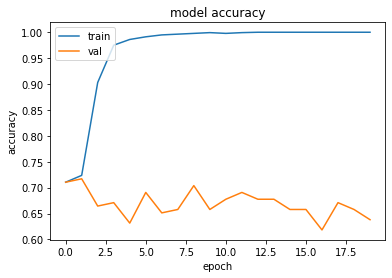

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

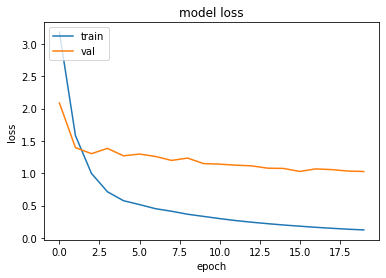

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test,batch_size=32)
print("loss: %s accuracy: %s precision: %s recall: %s" % (loss, accuracy, precision, recall))
df_evaluation = pd.DataFrame({'loss':loss, 'accuracy':accuracy, 'precision': precision, 'recall':recall},index=[0])

5/5 [==============================] - 0s 15ms/step - loss: 0.9588 - accuracy: 0.7039 - precision_6: 0.7039 - recall_6: 0.7039
loss: 0.9588055610656738 accuracy: 0.7039473652839661 precision: 0.7039473652839661 recall: 0.7039473652839661


In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/evaluation_logs_lstm_fox.csv'
df_evaluation.to_csv(name)
df_evaluation

,loss,accuracy,precision,recall
0,0.958806,0.703947,0.703947,0.703947


In [ ]:
Y_pred = model.predict(X_test)


In [ ]:
 Y_pred

array([[7.52954721e-01, 2.47045279e-01],
       [8.69950056e-01, 1.30050018e-01],
       [7.31912136e-01, 2.68087894e-01],
       [9.76363063e-01, 2.36368552e-02],
       [9.74933982e-01, 2.50659939e-02],
       [9.92702603e-01, 7.29735615e-03],
       [9.56174076e-01, 4.38259505e-02],
       [6.37625158e-01, 3.62374842e-01],
       [9.96337056e-01, 3.66292894e-03],
       [9.99748051e-01, 2.51887541e-04],
       [6.51204526e-01, 3.48795444e-01],
       [9.91050601e-01, 8.94945208e-03],
       [7.29187608e-01, 2.70812362e-01],
       [7.81326294e-01, 2.18673751e-01],
       [9.98013020e-01, 1.98698160e-03],
       [1.47689894e-01, 8.52310061e-01],
       [3.27588439e-01, 6.72411561e-01],
       [9.95689213e-01, 4.31076670e-03],
       [9.98144388e-01, 1.85567641e-03],
       [9.27431524e-01, 7.25684687e-02],
       [3.90200987e-02, 9.60979939e-01],
       [9.97831404e-01, 2.16862559e-03],
       [9.96521831e-01, 3.47814965e-03],
       [9.95606005e-01, 4.39397339e-03],
       [9.861789

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)
Y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
categories = ['not hate speech', 'hate speech']
 
report = classification_report(test_targets.values, Y_pred, target_names=categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
not hate speech,0.788618,0.836207,0.811715,116.000000
hate speech,0.344828,0.277778,0.307692,36.000000
accuracy,0.703947,0.703947,0.703947,0.703947
macro avg,0.566723,0.556992,0.559704,152.000000
weighted avg,0.683510,0.703947,0.692342,152.000000


In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/matrix_report_FoxNews.csv'
df_report.to_csv(name)

In [ ]:
df_results = pd.DataFrame(history.history)
df_results['learning_rate'] = lr
df_results['num_epochs'] = epochs
df_results['batch_size'] = batch_size
df_results['num_classes'] =  len(categories) 
df_results['test_size'] = test_size
df_results['train_size'] = len(train)
df_results['seed'] = seed
df_results['Tokenizer'] = 'keras_preprocessing.text.Tokenizer'
df_results['loss_function'] = 'categorical_crossentropy'
df_results['learning_rate'] = lr
df_results['train_class_proportion_' + categories[0]] = round(train_class_distribution[0][1], 2)
df_results['train_class_proportion_' + categories[1]] = round(train_class_distribution[1][1], 2)
df_results['test_class_proportion_' + categories[0]] = round(test_class_distribution[0][1], 2)
df_results['test_class_proportion_' + categories[1]] = round(test_class_distribution[1][1], 2)


In [ ]:
df_results.head()

,loss,accuracy,precision_6,recall_6,val_loss,val_accuracy,val_precision_6,val_recall_6,learning_rate,num_epochs,batch_size,num_classes,test_size,train_size,seed,Tokenizer,loss_function,train_class_proportion_not hate speech,train_class_proportion_hate speech,test_class_proportion_not hate speech,test_class_proportion_hate speech
0,3.285998,0.704248,0.704248,0.704248,2.206868,0.708029,0.708029,0.708029,0.001,20,32,2,0.1,1361,11,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.71,0.29,0.76,0.24
1,1.691625,0.714052,0.714052,0.714052,1.424249,0.715328,0.715328,0.715328,0.001,20,32,2,0.1,1361,11,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.71,0.29,0.76,0.24
2,1.074065,0.874183,0.874183,0.874183,1.306786,0.708029,0.708029,0.708029,0.001,20,32,2,0.1,1361,11,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.71,0.29,0.76,0.24
3,0.740160,0.968137,0.968137,0.968137,1.236140,0.671533,0.671533,0.671533,0.001,20,32,2,0.1,1361,11,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.71,0.29,0.76,0.24
4,0.602069,0.986111,0.986111,0.986111,1.348445,0.708029,0.708029,0.708029,0.001,20,32,2,0.1,1361,11,keras_preprocessing.text.Tokenizer,categorical_crossentropy,0.71,0.29,0.76,0.24


In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/training_logs_LSTM_FoxNews.csv'
df_results.to_csv(name)

In [ ]:
def plot_loss(path, ax, title):
    df = pd.read_csv(path)
    df.loss.plot(kind='line', legend=True, title=title, ax=ax, figsize=(15,8))
    ax.legend(loc='upper right')
    plt.xlabel('Step') 
    plt.ylabel('Loss')

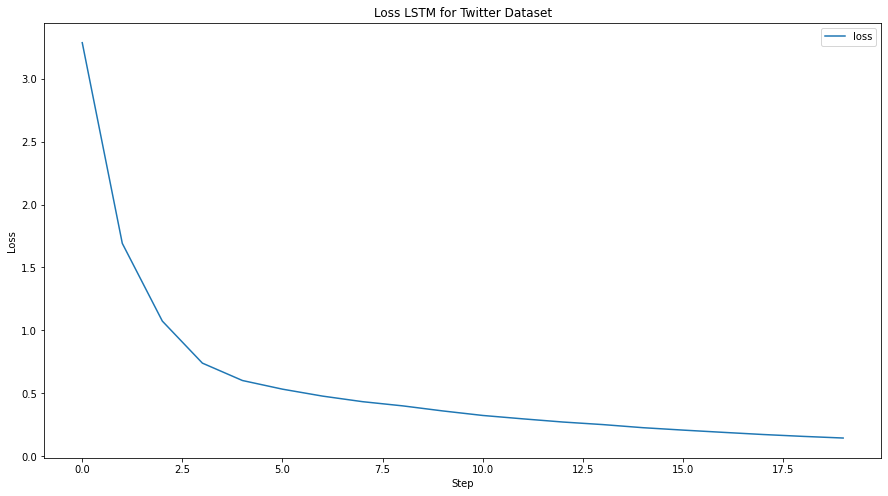

In [ ]:
fig, axs = plt.subplots(1,1)
path = '/content/drive/MyDrive/IAS/NLP_and_Web/report/training_logs_LSTM_FoxNews.csv'
plot_loss(path, axs, title='Loss LSTM for Twitter Dataset')

### Test the model on the 6 movies Dataset

In [ ]:
def annotate_all_movie(movie_df, X_test):
    utterances = X_test
    predictions = []
    batch = []
    

    predictions = model.predict(utterances)
    print(predictions)
    predictions = np.argmax(predictions, axis=1)
    print(predictions[0:10])


    result = []
    
    for i, pred in enumerate(predictions):
        result.append({'index': i, 'label_LSTM_FoxNews': pred})
    
    result_df = pd.DataFrame(result)
    movie_df = movie_df.merge(result_df, right_index=True, left_index=True)
    
    # del movie_df['Unnamed: 0']
    # del movie_df['Unnamed: 6']
    # del movie_df['Unnamed: 7']
    del movie_df['index']

    return movie_df

In [ ]:
annotated_all_movie =  annotate_all_movie(df_AllMovie, X_test_AllMovie) 
annotated_all_movie.head(10)

[[0.78684646 0.21315357]
 [0.84945023 0.15054984]
 [0.87533367 0.12466627]
 ...
 [0.96234727 0.0376527 ]
 [0.9152596  0.08474034]
 [0.9582269  0.04177304]]
[0 0 0 1 0 0 0 0 0 1]


,Unnamed: 0,movie_id,batch_id,majority_answer,text,movie_name,label_LSTM_FoxNews
0,0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX,0
1,1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX,0
2,2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX,0
3,3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX,1
4,4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX,0
5,5,AmericanHistoryX(1998)_6,1566624979,0,What's going on?,AmerricanHistoryX,0
6,6,AmericanHistoryX(1998)_7,1566624979,0,"Not right now, honey. How many?",AmerricanHistoryX,0
7,7,AmericanHistoryX(1998)_8,1566624979,0,"Danny, how many?",AmerricanHistoryX,0
8,8,AmericanHistoryX(1998)_9,1566624979,0,"One, I think.",AmerricanHistoryX,0
9,9,AmericanHistoryX(1998)_10,1566624979,0,Is he strapped?,AmerricanHistoryX,1


In [ ]:
annotated_all_movie.to_csv('/content/drive/MyDrive/IAS/NLP_and_Web/annotations/annotations_train_FoxNews_test_movies.csv')

In [ ]:
annotated_all_movie[(annotated_all_movie['majority_answer']==1)]['label_LSTM_FoxNews'].value_counts()

0    1385
1     289
Name: label_LSTM_FoxNews, dtype: int64

In [ ]:
categories = ['not hate speech', 'hate speech']
 
report = classification_report(annotated_all_movie['majority_answer'].values, annotated_all_movie['label_LSTM_FoxNews'].values, target_names=categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
not hate speech,0.847046,0.850899,0.848968,9014.000000
hate speech,0.176975,0.172640,0.174781,1674.000000
accuracy,0.744667,0.744667,0.744667,0.744667
macro avg,0.512010,0.511769,0.511874,10688.000000
weighted avg,0.742096,0.744667,0.743374,10688.000000


In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/matrix_report_train_FoxNews_test_movies.csv'
df_report.to_csv(name)

## Classication of Movies

### Load Movies

In [ ]:
def read_movie_files(pathes):
    result = []
    for path in pathes: 
        directory = os.fsencode(path)

        for file in os.listdir(directory):
            filename = os.fsdecode(file)

            if filename.endswith(".csv"):
                #print(os.path.join(directory, filename))
                #local_df = read_content(path + '//' + filename)
                movie_df = pd.read_csv(path + '//' + filename)
                tag = path.split('/')[-1]
                count_utterances = movie_df.shape[0]
                result.append({'movie_name': filename[:-9], 'count_utterances': count_utterances, 'tag': tag, 'path': path + '//' + filename})
    result_df = pd.DataFrame(result)
    return result_df

In [ ]:
pathes = ['drive/MyDrive/IAS/Semester3/NLP/movies/racism', 'drive/MyDrive/IAS/Semester3/NLP/movies/hate_speech', 'drive/MyDrive/IAS/Semester3/NLP/movies/friendship']

In [ ]:
movie_metadata_df = read_movie_files(pathes)
movie_metadata_df.head()

,movie_name,count_utterances,tag,path
0,A Time to Kill,2219,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
1,Apocalypse Now,2070,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
2,Amistad,1124,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
3,Bad Boys II,2394,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...
4,Angel Heart,910,racism,drive/MyDrive/IAS/Semester3/NLP/movies/racism/...


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba2dc2af98>],
      dtype=object)

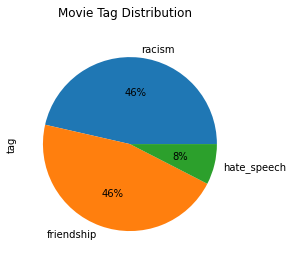

In [ ]:
movie_metadata_df.tag.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Movie Tag Distribution')

In [ ]:
path = 'drive/MyDrive/IAS/Semester3/NLP/data/all_movies.csv'
all_movie_data = pd.read_csv(path, index_col=0)

In [ ]:
all_movie_data.head()

,movie_name,index,utterance,count_utterances,tag
0,12 Angry Men,0,"Thank you very much, sir.",2065,racism
1,12 Angry Men,1,You did a wonderful job. Wonderful.,2065,racism
2,12 Angry Men,2,Shh. Shh.,2065,racism
3,12 Angry Men,3,"We did it, Pete. We did it.",2065,racism
4,12 Angry Men,4,"For a moment, we had our doubts.",2065,racism


In [ ]:
def annotate_single_movie(movie_df):
    utterances = movie_df.dialog.values
    predictions = []
    batch = []
    #doc_len = movie_df.dialog.apply(lambda words: len(words.split(" ")))
    #max_seq_len = np.round(doc_len.mean() + doc_len.std()).astype(int)
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(utterances)


 
    utterances = tokenizer.texts_to_sequences(utterances)
    # Pad the sentences
    utterances = pad_sequences(utterances, maxlen=maxlen)
    #print(utterances.shape)
    vocab_size = len(tokenizer.word_index) + 1
    #print(tokenizer.word_index)
    

    predictions = model.predict(utterances)
    predictions = np.argmax(predictions, axis=1)
    #print(predictions)


    result = []
    
    for i, pred in enumerate(predictions):
        result.append({'index': i, 'label_LSTM_FoxNews': categories[pred]})
    
    result_df = pd.DataFrame(result)
    movie_df = movie_df.merge(result_df, right_index=True, left_index=True)
    
    del movie_df['Unnamed: 0']
    del movie_df['index']

    return movie_df
    

## Annotate Movies

In [ ]:
movie_df = pd.read_csv(pathes[0]+'/12 Angry Men_conv.csv')

In [ ]:
movie_df.head()

,Unnamed: 0,dialog
0,0,"Thank you very much, sir."
1,1,You did a wonderful job. Wonderful.
2,2,Shh. Shh.
3,3,"We did it, Pete. We did it."
4,4,"For a moment, we had our doubts."


In [ ]:
annotate_single_movie(movie_df)

,dialog,label_LSTM_twitter
0,"Thank you very much, sir.",not hate speech
1,You did a wonderful job. Wonderful.,not hate speech
2,Shh. Shh.,not hate speech
3,"We did it, Pete. We did it.",not hate speech
4,"For a moment, we had our doubts.",not hate speech
...,...,...
2060,What's your name?,not hate speech
2061,Davis.,not hate speech
2062,My name's McCardle.,not hate speech
2063,"Well, so long.",not hate speech


In [ ]:
def movie_data_cleansing(df):
    df = df.replace(r'<[^\\]>', '', regex=True)
    df = df.replace(r'<\\.*>', '', regex=True)
    return df

In [ ]:
def annotate_movies(movie_metadata_df):
    
    pathes = movie_metadata_df.path.values
    tags = movie_metadata_df.tag.values
    movie_names = movie_metadata_df.movie_name.values
    
    result = []
    for i in range(0, movie_metadata_df.shape[0]):
        path = pathes[i]
        tag = tags[i]
        movie_name = movie_names[i]
        print(i+1, movie_metadata_df.shape[0], path, tag, movie_name)
        movie_df = pd.read_csv(path)
        movie_df = movie_data_cleansing(movie_df)
        movie_df = movie_data_cleansing(movie_df)
        movie_df = annotate_single_movie(movie_df)
        
        labels = movie_df.label_LSTM_twitter.values
                
        for i in range(0, len(labels)):
            result.append({'movie_name': movie_name, 'index': i, 'label': labels[i]})
                    
    result_df = pd.DataFrame(result)     
    return result_df

In [ ]:
movies_annotated_df = annotate_movies(movie_metadata_df)

1 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//A Time to Kill_conv.csv racism A Time to Kill
2 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Apocalypse Now_conv.csv racism Apocalypse Now
3 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Amistad_conv.csv racism Amistad
4 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Bad Boys II_conv.csv racism Bad Boys II
5 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Angel Heart_conv.csv racism Angel Heart
6 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Bone Tomahawk_conv.csv racism Bone Tomahawk
7 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Enter the Dragon_conv.csv racism Enter the Dragon
8 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Dragged Across Concrete_conv.csv racism Dragged Across Concrete
9 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Antebellum_conv.csv racism Antebellum
10 252 drive/MyDrive/IAS/Semester3/NLP/movies/racism//Empire of the Sun_conv.csv racism Empire of the Sun
11 252 drive/MyDr

In [ ]:
movies_annotated_df.to_csv('drive/MyDrive/IAS/Semester3/NLP/annotations/annotations_LSTM_FoxNews.csv')